In [1]:
import torch

In [2]:
from load_data import *

In [3]:
device = torch.device('cuda')

# Load Dataset
- load_adult_data
- load_german_data
- load_bank_data
- load_compas_data

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_compas_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))


Number of people recidivating within two years
0    2795
1    2483
dtype: int64




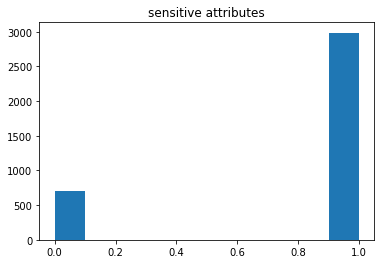

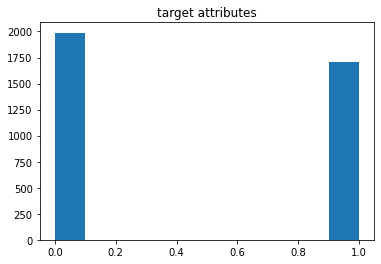

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [6]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.19139145]
training default:  [0.53817001]
test default:  [0.5094697]


In [7]:
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)


# training samples: (3694, 7)
# test samples: (1584, 7)
# sensitive vars (3694, 1)


In [8]:
N1 = 100
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [9]:
np.unique(Ztr)

array([0, 1])

In [10]:
Ztr.shape

(3694, 1)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
from fairNN_train import *
from load_data import *

In [13]:
class Args:
    def __init__(self):
        self.epochs = 30
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 32
        self.AL_select = 'loss'
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [14]:
args = Args()

In [15]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [16]:
from fair_eval import *

In [17]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [18]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

- gradient calculation for unlabeled set
- expectation 
- https://discuss.pytorch.org/t/how-to-efficiently-compute-gradient-for-each-training-sample/60001/2 
- https://github.com/cybertronai/autograd-hacks#per-example-gradients 
- https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html

# Group Selection Part

## Test Group Performance

## find examples for the worst group

In [19]:
from fairAL_utils import *

In [20]:
train_loader.dataset.tensors[0].size(0)

100

## retraining models

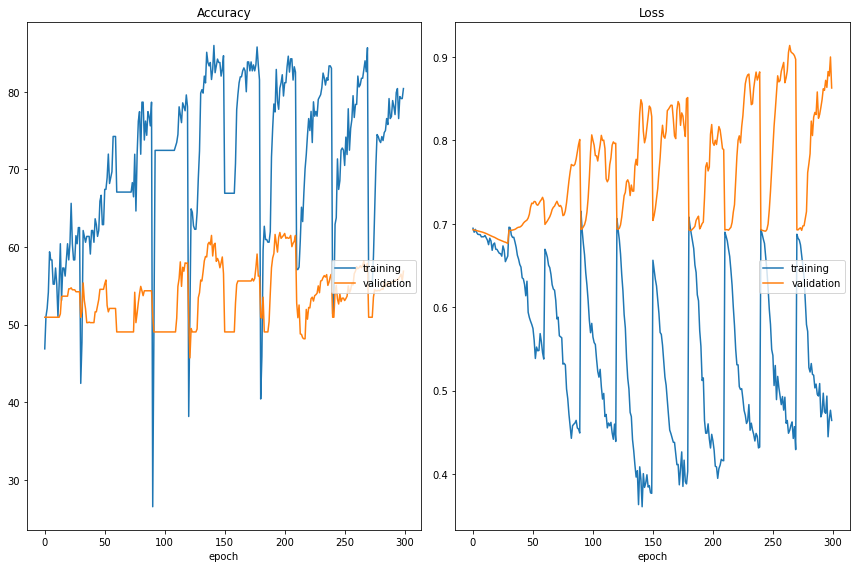

Accuracy
	training         	 (min:   26.531, max:   85.965, cur:   80.412)
	validation       	 (min:   45.707, max:   61.869, cur:   56.881)
Loss
	training         	 (min:    0.361, max:    0.715, cur:    0.464)
	validation       	 (min:    0.676, max:    0.914, cur:    0.863)
Finished Training
0.0 : loss 0.6571707725524902 / acc 71.42857360839844
1.0 : loss 0.42450833320617676 / acc 85.02674102783203


In [21]:
clf,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, random_sel = False)

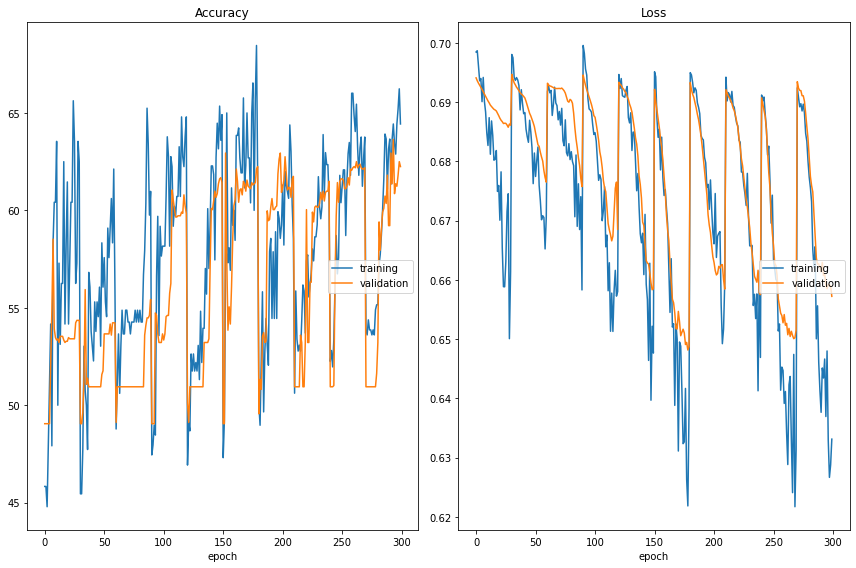

Accuracy
	training         	 (min:   44.792, max:   68.462, cur:   64.433)
	validation       	 (min:   49.053, max:   63.636, cur:   62.247)
Loss
	training         	 (min:    0.622, max:    0.700, cur:    0.633)
	validation       	 (min:    0.648, max:    0.695, cur:    0.657)
Finished Training
0.0 : loss 0.5079763531684875 / acc 76.38888549804688
1.0 : loss 0.643602192401886 / acc 64.24050903320312


In [22]:
clf2,_,_ = train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = True, random_sel = True)

In [24]:
clf_criterion = nn.BCELoss()
print("training performances")
test_groupwise(clf,train_loader, clf_criterion, device,args)
print(test_model(clf, train_loader, clf_criterion, device))
print("test performances")
test_groupwise(clf,test_loader, clf_criterion, device,args)
print(test_model(clf, test_loader, clf_criterion, device))
print("select performances")
test_groupwise(clf,select_loader, clf_criterion, device,args)
print(test_model(clf, select_loader, clf_criterion, device))

training performances
0.0 : loss 0.6571707725524902 / acc 71.42857360839844
1.0 : loss 0.7520668506622314 / acc 62.79069900512695
(tensor(0.7317), tensor(65.6250))
test performances
0.0 : loss 0.7467077970504761 / acc 62.96296310424805
1.0 : loss 0.8924931883811951 / acc 55.31745910644531
(tensor(0.8627), tensor(56.8813))
select performances
0.0 : loss 0.8280149698257446 / acc 59.30735778808594
1.0 : loss 0.8341464996337891 / acc 59.08307647705078
(tensor(0.8330), tensor(59.1263))


In [25]:
clf_criterion = nn.BCELoss()
print("training performances")
test_groupwise(clf2,train_loader, clf_criterion, device,args)
print(test_model(clf2, train_loader, clf_criterion, device))
print("test performances")
test_groupwise(clf2,test_loader, clf_criterion, device,args)
print(test_model(clf2, test_loader, clf_criterion, device))
print("select performances")
test_groupwise(clf2,select_loader, clf_criterion, device,args)
print(test_model(clf2, select_loader, clf_criterion, device))

training performances
0.0 : loss 0.5336017608642578 / acc 71.42857360839844
1.0 : loss 0.6601768136024475 / acc 62.79069900512695
(tensor(0.6394), tensor(64.5833))
test performances
0.0 : loss 0.6693195700645447 / acc 62.03703689575195
1.0 : loss 0.6541046500205994 / acc 62.30158615112305
(tensor(0.6572), tensor(62.2475))
select performances
0.0 : loss 0.659510612487793 / acc 64.79076385498047
1.0 : loss 0.6511566638946533 / acc 62.25439453125
(tensor(0.6528), tensor(62.7435))
